## V8_Infra_Score_LightGBM_kfold5

In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [2]:
raw_path: str = "../../../data/raw"
processed_path: str = "../../../data/processed"
submission_path: str = "../../../data/submission"

In [3]:
v8: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"V8+subway_1.csv"))

In [8]:
v8['subway_1'].value_counts()

subway_1
0    1895830
1      26076
2      12437
3       8876
4       6088
5       2093
Name: count, dtype: int64

In [16]:
import time
from datetime import datetime
v8['contract_date'] = pd.to_datetime(v8['contract_date_numeric'], format='%Y%m%d')
v8['contract_timestamp'] = v8['contract_date'].apply(lambda x: int(time.mktime(x.timetuple())))
print(v8[['contract_date_numeric', 'contract_date', 'contract_timestamp']].head())

   contract_date_numeric contract_date  contract_timestamp
0               20190625    2019-06-25          1561388400
1               20200326    2020-03-26          1585148400
2               20200328    2020-03-28          1585321200
3               20190715    2019-07-15          1563116400
4               20190412    2019-04-12          1554994800


### Arima_Deposit_Index 추가

### 컬럼 정리

In [31]:
# columns_to_drop = ['contract_type', 'contract_2','area_m2_price', 'area_price', 'date', 'contract_ymd', 'original_index', 'interest_rate', 'diff_interest_rate']
# df = v4_arima_contract_type.drop(columns=columns_to_drop, errors='ignore')

columns = ['index','_type',
    'area_m2', 'contract_timestamp',
    'floor', 'built_year', 'latitude', 'longitude', 'age',
    'contract_0', 'contract_1',
    'deposit',
    'apt_idx',
    'area',
    'grid_id',
    'nearest_subway_distance',
    'nearest_subway_idx',
    'nearest_park_distance',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit',
    'nearest_park_idx',
    'nearest_school_idx',
    'nearest_school_distance',
    'park_area','subway_1']
df = v8.filter(items=columns)

df['recent_deposit'] = df['recent_deposit'].fillna(39000)
temp_train_df = df[df["_type"]=='train']
test_df = df[df["_type"]=='test']

## K-Fold CV(k=5) 적용 LightGBM

In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 학습에 사용할 특징 열
feature_columns = [col for col in temp_train_df.columns if col not in ['deposit', '_type', 'index']]

# 학습 데이터 준비
X = temp_train_df[feature_columns]
y = temp_train_df['deposit']

# 결측치 대체
# X['recent_deposit'] = X['recent_deposit'].fillna(39000)

# LightGBM 파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'early_stopping_round' : 500
}

# 콜백 함수 정의
def print_evaluation(period=10):
    def callback(env):
        if (env.iteration + 1) % period == 0:
            train_mae = env.evaluation_result_list[0][2]
            val_mae = env.evaluation_result_list[1][2]
            print(f"[{env.iteration + 1}] Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")
    return callback

# 5-fold 교차 검증 설정
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# 각 폴드의 예측 결과를 저장할 리스트
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(test_df))

# 교차 검증 수행
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    model = lgb.train(
        params, 
        dtrain, 
        num_boost_round=2500, 
        valid_sets=[dtrain, dval], 
        callbacks=[print_evaluation(period=100)],
    )
    
    # 검증 세트에 대한 예측
    oof_predictions[val_idx] = model.predict(X_val)
    
    # 테스트 세트에 대한 예측
    test_predictions += model.predict(test_df[feature_columns]) / n_folds

# 전체 검증 세트에 대한 MAE 계산
oof_mae = mean_absolute_error(y, oof_predictions)
print(f"\nOverall OOF MAE: {oof_mae:.4f}")

# 테스트 세트에 대한 최종 예측 결과
y_pred = test_predictions

print("\nTraining completed.")


Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4494
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 23
[LightGBM] [Info] Start training from score 38183.560818
Training until validation scores don't improve for 500 rounds
[100] Train MAE: 4137.9893, Val MAE: 4132.0685
[200] Train MAE: 4012.2830, Val MAE: 4015.3080
[300] Train MAE: 3970.1139, Val MAE: 3979.2938
[400] Train MAE: 3938.8374, Val MAE: 3954.6104
[500] Train MAE: 3917.2609, Val MAE: 3938.1592
[600] Train MAE: 3898.8871, Val MAE: 3925.2889
[700] Train MAE: 3880.3696, Val MAE: 3911.3398
[800] Train MAE: 3864.3732, Val MAE: 3900.3529
[900] Train MAE: 3849.7002, Val MAE: 3890.6050
[1000] Train MAE: 3837.1524, Val MAE: 3882.7240
[1100] Train MAE: 3827.2921, Val MAE: 3877.0788

### Feature Importance

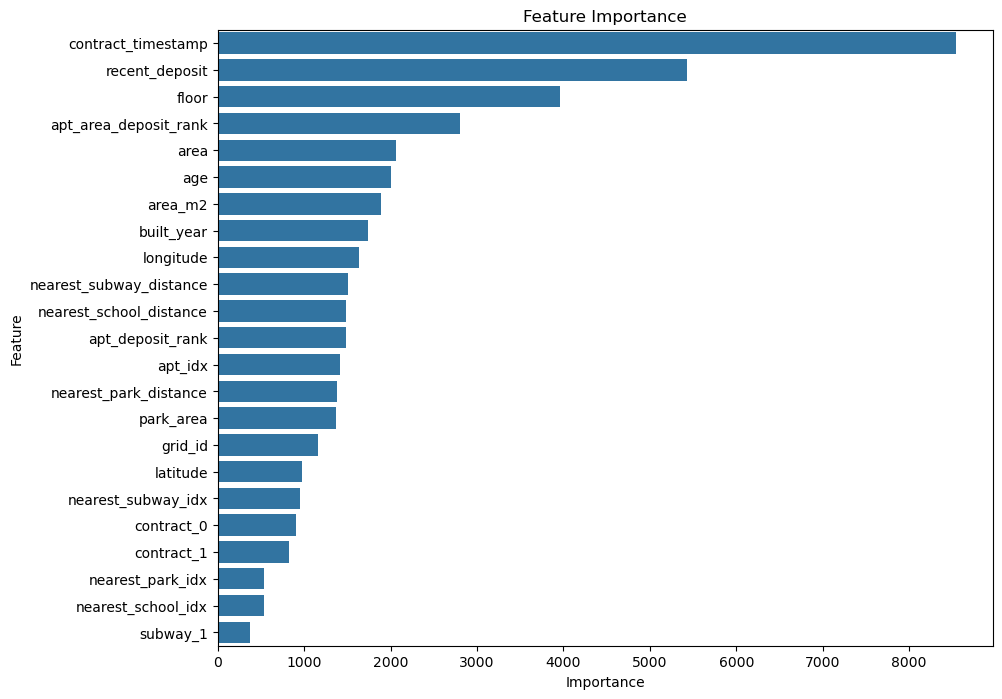

In [26]:
# LightGBM 모델의 피처 중요도 추출
feature_importance = model.feature_importance()

# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [28]:
y_pred

array([22002.78746662,  7259.93392324,  5849.49764324, ...,
       44897.22663708, 37203.42958659, 37708.60345114])

In [29]:
# Create a DataFrame from y_pred with the same index as X_test
y_pred_df = pd.DataFrame(y_pred, index=range(len(y_pred)), columns=['deposit'])

# Display the DataFrame
y_pred_df.index.name = 'index'
y_pred_df

,deposit
index,
0,22002.787467
1,7259.933923
2,5849.497643
3,5692.276126
4,5877.143099
...,...
150167,36965.669450
150168,43812.564815
150169,44897.226637


In [30]:
y_pred_df['deposit'].mean()

np.float64(39153.68387758537)

In [15]:
y_pred_df.to_csv(os.path.join(submission_path, "V8+sub1_lightGBM_Kfold5.csv"), index=True)